Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Serath Chandra Nutakki"
COLLABORATORS = "serathch"

---

# Lab 2


### Due Thursday 12/2/2021 @ 11:59 PM EST (New York) 




### Objectives of Lab 2
1. Parse a large 'messy' file
1. Create a normalized database from a large 'messy' file
1. Optimize code to load 600,000+ rows into a database quickly
1. Practice SQL queries
1. Create plots to visualize the data -- I have already done this for you!


### Description of data
Open `lab2_data.csv` file and understand its contents. The file consists
of 11 columns separated by tab and each row is a customer with all of the products they have ordered. The columns are:
1. Name -- The `Name` column is made up of the customer `FirstName` and `LastName` separated by a space 
1. Address -- The `Address` column has the customer address 
1. City -- The `City` column has the customer city 
1. Country -- The `Country` column has the customer country 
1. Region -- The `Region` column has the customer region 
1. ProductName* 
1. ProductCategory*
1. ProductCategoryDescription*
1. ProductUnitPrice*
1. QuantityOrderded*
1. OrderDate*

All the `*` columns are linked, meaning if you split the columns on a semicolon and zip them up, you will get one product name, product category, product category description, product unit price, quantity ordered, and ordered date. Remember, each row/line in the data represents a customer and all their product orders. The product orders are separated by a semicolon. 

In this lab you will parse the data file and create a normalized database with six tables. To make this lab manageable, I will lay down the steps you need to create the following tables:
```SQL
Region 
  [RegionID] Integer not null primary key
  [Region] Text not null
Country
  [CountryID] integer not null Primary key
  [Country] Text not null
Customer
  [CustomerID] integer not null Primary Key
  [FirstName] Text not null
  [LastName] Text not null
  [Address] Text not null
  [City] Text not null
  [CountryID] integer not null foreign key to Country table
  [RegionID] integer not null foreign key to Region table
ProductCateogry
  [ProductCategoryID] integer not null Primary Key
  [ProductCategory] Text not null
  [ProductCategoryDescription] Text not null
Product
  [ProductID] integer not null Primary key
  [ProductName] Text not null
  [ProductUnitPrice] Real not null
  [ProductCategoryID] integer not null foreign key to ProductCateogry table
OrderDetail
  [OrderID] integer not null Primary Key
  [CustomerID] integer not null foreign key to Customer table
  [ProductID] integer not null foreign key to Product table
  [OrderDate] integer not null 
  [QuantityOrdered] integer not null
```

### Hints
Note: The `create_table` function has been updated. Please study it and try to understand how it is different. You can now use it to drop a table before inserting into it. This is useful because you do not have to start from scratch. You can drop an individual table before recreating it if it exists. 

Also checkout out this link to understand how `executemany` works: https://www.kite.com/python/docs/sqlite3.Cursor.executemany and incorporate it into your insert_table functions. If you use `execute`, your insertions will be very slow. If you have only one value to insert, the values tuple will look like 
```python
values = (('Graduate', ), ('Undergraduate',))
```

Always, always use the `with` context to insert. 

#### Note: There is one manually graded part of this lab which I will use to make sure you guys are using `executemany` and not `execute` to insert into the tables. 

# DO NOT USE PANDAS to manipulate the data; I will deduct points for using PANDAS;
# DO NOT USE CSV module to read the data; I will deduct points for using the CSV module;

In [7]:
### Utility Functions
from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows


In [8]:
# Delete old database file

normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename, delete_db=True)


# Step 1 - Create the Region Table

### Tasks

1. Loop over the data and find the distinct regions
1. Create the region table
1. Populate the region table with the distinct regions. Make sure to sort the regions before inserting.  

In [9]:
def step1_create_region_table(data_filename, normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: None

    
    # YOUR CODE HERE
    csv_file =  read_csv(data_filename)
    conn = create_connection(normalized_database_filename, True)
    
    insert_region = []
    for i in range(1,len(csv_file)):
        if csv_file[i][4] not in insert_region:
            x = csv_file[i][4]
            insert_region.append(x)
    insert_region.sort()
    Region = list(map(lambda x: (x,), insert_region))
    #print(Region)   
    
    create_table_sql = "CREATE TABLE IF NOT EXISTS Region([RegionID] Integer NOT NULL primary key,[Region] Text NOT NULL)"
    create_table(conn, create_table_sql)
  #  print(execute_sql_statement("pragma table_info('Region')",conn));
       
    
    with conn:
        sql = ''' INSERT INTO Region(Region)
              VALUES(?) '''
        cur = conn.cursor()
        cur.executemany(sql, Region)
        
conn.close()

    
def read_csv(data_filename):
    with open(data_filename, 'r') as file:
        val_list = []
        for line in file:
            if not line.strip():
                continue
            values = line.strip().split('\t')
            val_list.append(values)
    return val_list    

    
    
    
    
    

In [11]:
# 5 Points
data_filename = 'data.csv'
normalized_database_filename = 'normalized.db'
step1_create_region_table(data_filename, normalized_database_filename)
data = pd.read_csv("step1.csv")
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM Region""", conn)
assert df.equals(data) == True

# Step 2 - Create the Country Table

### Tasks

1. Loop over the data and find the distinct countries
1. Create the country table
1. Populate the country table with the distinct countries. Make sure to sort the countries before inserting.  

In [6]:
def step2_create_country_table(data_filename, normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: None
    
    # YOUR CODE HERE
    csv_file =  read_csv(data_filename)
    conn = create_connection(normalized_database_filename)
    
    insert_country = []
    for i in range(1,len(csv_file)):
        if csv_file[i][3] not in insert_country:
            x = csv_file[i][3]
            insert_country.append(x)
    insert_country.sort()
    Country = list(map(lambda x: (x,), insert_country))
    
    create_table_sql = "CREATE TABLE IF NOT EXISTS Country([CountryID] integer not null Primary key,[Country] Text not null)"
    create_table(conn, create_table_sql)
    
    with conn:
        sql = ''' INSERT INTO Country(Country)
              VALUES(?) '''
        cur = conn.cursor()
        cur.executemany(sql, Country)

conn.close()
    

In [7]:
# 5 Points
data_filename = 'lab2_data.csv'
normalized_database_filename = 'normalized.db'
step2_create_country_table(data_filename, normalized_database_filename)
data = pd.read_csv("step2.csv")
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM Country""", conn)
assert df.equals(data) == True

# Step 3 - Create dictionary to map Region to RegionID

The purpose of this step is to create a dictionary to look up the primary key lookup for a given region. 

Tasks
1. Write an SQL query to fetch all the rows from the Region table
1. Transform the row into a dictionary whose key is Region and value is RegionID



In [8]:
def step3_create_region_to_regionid_dictionary(normalized_database_filename):
    
    
    # YOUR CODE HERE
    conn = create_connection(normalized_database_filename)
    
    sql_statement = "SELECT * from Region"
    values = execute_sql_statement(sql_statement, conn)
    
    Region_lookup = {}
    for RegionID, Region in values:
        Region_lookup[Region] = RegionID
    return(Region_lookup)

In [9]:
# 5 Points
normalized_database_filename = 'normalized.db'
region_to_regionid_dict = step3_create_region_to_regionid_dictionary(normalized_database_filename)
expected_solution = {
    'British Isles': 1,
    'Central America': 2,
    'Eastern Europe': 3, 
    'North America': 4,
    'Northern Europe': 5,
    'Scandinavia': 6, 
    'South America': 7,
    'Southern Europe': 8,
    'Western Europe': 9
}
assert expected_solution == region_to_regionid_dict

# Step 4 - Create dictionary to map Country to CountryID

The purpose of this step is to create a dictionary to look up the primary key lookup for a given country. 


Tasks
1. Write an SQL query to fetch all the rows from the Country table
1. Transform the row into a dictionary whose key is Country and value is CountryID

In [10]:
def step4_create_country_to_countryid_dictionary(normalized_database_filename):
    
    
    # YOUR CODE HERE
    conn = create_connection(normalized_database_filename)
    
    sql_statement = "SELECT * from Country"
    values = execute_sql_statement(sql_statement, conn)
    
    Country_lookup = {}
    for CountryID, Country in values:
        Country_lookup[Country] = CountryID
    return(Country_lookup)

In [11]:
# 5 Points
normalized_database_filename = 'normalized.db'
country_to_countryid_dict = step4_create_country_to_countryid_dictionary(normalized_database_filename)
expected_solution = {
    'Argentina': 1, 
    'Austria': 2, 
    'Belgium': 3, 
    'Brazil': 4,
    'Canada': 5, 
    'Denmark': 6, 
    'Finland': 7, 
    'France': 8, 
    'Germany': 9, 
    'Ireland': 10, 
    'Italy': 11, 
    'Mexico': 12, 
    'Norway': 13, 
    'Poland': 14, 
    'Portugal': 15,
    'Spain': 16, 
    'Sweden': 17, 
    'Switzerland': 18,
    'UK': 19, 
    'USA': 20, 
    'Venezuela': 21
}
assert expected_solution == country_to_countryid_dict

# Step 5 - Create the customer table

Note: You will be using `region_to_regionid_dict` and `country_to_countryid_dict` in this step when inserting into the customer table. Both should already be available inside the step5 function, so you can just use them. 

Tasks
1. Loop over the data file and grab the name, address, city, country and region
1. Create the customer table
1. Populate the customer table

### NOTE!
- One of name when split on space results in three elements. In this case, the first name is the first element and the other two elements in the last name. 
- Insert the names sorted by first and lastname as one string. Hint: user lambda to combine first and last name and sort. 

In [12]:
def step5_create_customer_table(data_filename, normalized_database_filename):

    # YOUR CODE HERE
    csv_file =  read_csv(data_filename)
    conn = create_connection(normalized_database_filename)
    
    RegionID = []
    for i in range(1,len(csv_file)):
        RegionID.append(region_to_regionid_dict[csv_file[i][4]])
    
    CountryID = []
    for i in range(1,len(csv_file)):
        CountryID.append(country_to_countryid_dict[csv_file[i][3]])
        
    name = []
    for i in range(1,len(csv_file)):
        name.append((csv_file[i][0].split(' ', 1)[0].strip(), csv_file[i][0].split(' ', 1)[1].strip()))
    name.sort()
#     print(name)
    
    insert_address = []
    for i in range(1,len(csv_file)):
            x = csv_file[i][1].strip()
            insert_address.append(x)
    Address = list(map(lambda x: (x,), insert_address))
    #print(Address)
    
    insert_city = []
    for i in range(1,len(csv_file)):
            x = csv_file[i][2].strip()
            insert_city.append(x)
    City = list(map(lambda x: (x,), insert_city))
    
    final = []
    for i in range(len(name)):
        final.append((name[i][0],name[i][1],Address[i][0],City[i][0],int(CountryID[i]),int(RegionID[i]),))
    
    
    create_table_sql= "CREATE TABLE IF NOT EXISTS Customer ([CustomerID] INTEGER PRIMARY KEY, [FirstName] TEXT NOT NULL, [LastName] TEXT NOT NULL, [Address] TEXT NOT NULL, [City] TEXT NOT NULL, [CountryID] INTEGER NOT NULL, [RegionID] INTEGER NOT NULL, FOREIGN KEY(CountryID) REFERENCES Country(CountryID), FOREIGN KEY(RegionID) REFERENCES Region(RegionID))"
    create_table(conn, create_table_sql)
    
    
    with conn:
        sql = ''' INSERT INTO Customer(FirstName,LastName,Address,City,CountryID,RegionID)
              VALUES(?,?,?,?,?,?) '''
        cur = conn.cursor()
        cur.executemany(sql,final)
        
conn.close()

In [13]:
# 10 Points
normalized_database_filename = 'normalized.db'
data_filename = 'lab2_data.csv'
step5_create_customer_table(data_filename, normalized_database_filename)
data = pd.read_csv("step5.csv")
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM Customer""", conn)
assert df.equals(data) == True

# Step 6 - Create dictionary to map Name (FirstName LastName) to CustomerID

The purpose of this step is to create a dictionary to look up the primary key lookup for a given name (FirstName LastName)

Tasks
1. Write an SQL query to fetch all the rows from the Customer table
1. Transform the row into a dictionary whose key is the name of the customer (FirstName LastName) and value is CustomerID



In [14]:
def step6_create_customer_to_customerid_dictionary(normalized_database_filename):
    
    
    # YOUR CODE HERE
    conn = create_connection(normalized_database_filename)
    
    sql_statement = "SELECT * from Customer"
    values = execute_sql_statement(sql_statement, conn)
    Name_lookup = {}
    for CustomerID, FirstName,LastName,Adddress,City,CountryID,RegionID in values:
        Name = f'{FirstName} {LastName}'
        Name_lookup[Name] = CustomerID
    return(Name_lookup)
          

In [15]:
# 5 Points
normalized_database_filename = 'normalized.db'
customer_to_customerid_dict = step6_create_customer_to_customerid_dictionary(normalized_database_filename)
expected_solution = {
     'Alejandra Camino': 1,
     'Alexander Feuer': 2,
     'Ana Trujillo': 3,
     'Anabela Domingues': 4,
     'André Fonseca': 5,
     'Ann Devon': 6,
     'Annette Roulet': 7,
     'Antonio Moreno': 8,
     'Aria Cruz': 9,
     'Art Braunschweiger': 10,
     'Bernardo Batista': 11,
     'Carine Schmitt': 12,
     'Carlos González': 13,
     'Carlos Hernández': 14,
     'Catherine Dewey': 15,
     'Christina Berglund': 16,
     'Daniel Tonini': 17,
     'Diego Roel': 18,
     'Dominique Perrier': 19,
     'Eduardo Saavedra': 20,
     'Elizabeth Brown': 21,
     'Elizabeth Lincoln': 22,
     'Felipe Izquierdo': 23,
     'Fran Wilson': 24,
     'Francisco Chang': 25,
     'Frédérique Citeaux': 26,
     'Georg Pipps': 27,
     'Giovanni Rovelli': 28,
     'Guillermo Fernández': 29,
     'Hanna Moos': 30,
     'Hari Kumar': 31,
     'Helen Bennett': 32,
     'Helvetius Nagy': 33,
     'Henriette Pfalzheim': 34,
     'Horst Kloss': 35,
     'Howard Snyder': 36,
     'Isabel de Castro': 37,
     'Jaime Yorres': 38,
     'Janete Limeira': 39,
     'Janine Labrune': 40,
     'Jean Fresnière': 41,
     'John Steel': 42,
     'Jonas Bergulfsen': 43,
     'Jose Pavarotti': 44,
     'José Pedro Freyre': 45,
     'Jytte Petersen': 46,
     'Karin Josephs': 47,
     'Karl Jablonski': 48,
     'Laurence Lebihan': 49,
     'Lino Rodriguez': 50,
     'Liu Wong': 51,
     'Liz Nixon': 52,
     'Lúcia Carvalho': 53,
     'Manuel Pereira': 54,
     'Maria Anders': 55,
     'Maria Larsson': 56,
     'Marie Bertrand': 57,
     'Mario Pontes': 58,
     'Martine Rancé': 59,
     'Martín Sommer': 60,
     'Mary Saveley': 61,
     'Matti Karttunen': 62,
     'Maurizio Moroni': 63,
     'Michael Holz': 64,
     'Miguel Angel Paolino': 65,
     'Palle Ibsen': 66,
     'Paolo Accorti': 67,
     'Pascale Cartrain': 68,
     'Patricia McKenna': 69,
     'Patricio Simpson': 70,
     'Paul Henriot': 71,
     'Paula Parente': 72,
     'Paula Wilson': 73,
     'Pedro Afonso': 74,
     'Peter Franken': 75,
     'Philip Cramer': 76,
     'Pirkko Koskitalo': 77,
     'Renate Messner': 78,
     'Rene Phillips': 79,
     'Rita Müller': 80,
     'Roland Mendel': 81,
     'Sergio Gutiérrez': 82,
     'Simon Crowther': 83,
     'Sven Ottlieb': 84,
     'Thomas Hardy': 85,
     'Victoria Ashworth': 86,
     'Yang Wang': 87,
     'Yoshi Latimer': 88,
     'Yoshi Tannamuri': 89,
     'Yvonne Moncada': 90,
     'Zbyszek Piestrzeniewicz': 91
}

assert expected_solution == customer_to_customerid_dict

# Step 7 - Create Product Category Table

### Tasks

1. Loop over the data and find the distinct product categories
1. Create the product category table
1. Populate the product category table with the distinct product categories. Make sure to sort the categories before inserting.  

In [14]:
def step7_create_productcategory_table(data_filename, normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: None
    
    
    # YOUR CODE HERE
    csv_file =  read_csv(data_filename)
    conn = create_connection(normalized_database_filename)

    insert_product = []

    for i in range(1,len(csv_file)):
        product_category = csv_file[i][6].split(';')
        product_category_description = csv_file[i][7].split(';')
        for (x,y) in zip(product_category,product_category_description):
                if (x,y,) not in insert_product:
                    insert_product.append((x,y,))
                    
    insert_product.sort(key=lambda i : i[0])

       
    create_table_sql = """CREATE TABLE IF NOT EXISTS ProductCategory([ProductCategoryID] INTEGER NOT NULL Primary key, [ProductCategory] Text NOT NULL,[ProductCategoryDescription] TEXT NOT NULL)"""
    create_table(conn, create_table_sql)
        
    with conn:
        sql = ''' INSERT INTO ProductCategory(ProductCategory, ProductCategoryDescription)
              VALUES(?,?) '''
        cur = conn.cursor()
        cur.executemany(sql,insert_product)
        
conn.close()
    

In [16]:
# 5 Points
normalized_database_filename = 'normalized.db'
data_filename = 'data.csv'
step7_create_productcategory_table(data_filename, normalized_database_filename)
data = pd.read_csv("step7.csv")
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProductCategory""", conn)
assert df.equals(data) == True

# Step 8 - Create dictionary to map productcategory to productcategoryid

The purpose of this step is to create a dictionary to look up the primary key lookup for a given product category

Tasks
1. Write an SQL query to fetch all the rows from the product category table
1. Transform the row into a dictionary whose key is the product category and value is product category id




In [17]:
def step8_create_productcategory_to_productcategoryid_dictionary(normalized_database_filename):
    
    
    # YOUR CODE HERE
    conn = create_connection(normalized_database_filename)
    
    sql_statement = "SELECT * from ProductCategory"
    values = execute_sql_statement(sql_statement, conn)
    
    ProductCategory_lookup = {}
    for ProductCategoryID, ProductCategory,ProductCategoryDescription in values:
        ProductCategory_lookup[ProductCategory] = ProductCategoryID
    return(ProductCategory_lookup)        

In [18]:
# 5 Points
normalized_database_filename = 'normalized.db'
productcategory_to_productcategoryid_dict = step8_create_productcategory_to_productcategoryid_dictionary(normalized_database_filename)
expected_solution = {
    'Beverages': 1,
    'Condiments': 2,
    'Confections': 3,
    'Dairy Products': 4,
    'Grains/Cereals': 5,
    'Meat/Poultry': 6,
    'Produce': 7,
    'Seafood': 8
}
assert expected_solution == productcategory_to_productcategoryid_dict

# Step 9 - Create Product Table

Note: You will be using `productcategory_to_productcategoryid_dict` in this step when inserting into the product table.

### Tasks

1. Loop over the data and find the distinct products
1. Create the product table
1. Populate the product table with the distinct products. Make sure to sort the products (by name) before inserting.  

In [19]:
def step9_create_product_table(data_filename, normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: None

    
    # YOUR CODE HERE
    csv_file =  read_csv(data_filename)
    conn = create_connection(normalized_database_filename)
    
    dictn = step8_create_productcategory_to_productcategoryid_dictionary(normalized_database_filename)
    product_name = []
    prod_price = []
    product_cat = []
    data_dic = {}
    i = 1
    while(i<len(csv_file)):
        product_name.append(csv_file[i][5].strip(" ").split(";"))
        prod_price.append(csv_file[i][8].strip(" ").split(";"))
        product_cat.append(csv_file[i][6].strip(" ").split(";"))
        i+=1

    i = 1
    while(i<len(product_name)):
        j = 0
        while(j<len(product_name[i])):
            if product_name[i][j] not in data_dic:
                data_dic[product_name[i][j]] = (product_name[i][j], float(prod_price[i][j]), dictn[product_cat[i][j]])
            j+=1
        i+=1

    data_dic = dict(sorted(data_dic.items(), key=lambda i: i[0]))
    data = []
    count=1
    for i in data_dic:
        data.append((count,data_dic[i][0],data_dic[i][1],data_dic[i][2]))
        count+=1
    create_table_sql = """CREATE TABLE IF NOT EXISTS Product([ProductID] INTEGER NOT NULL Primary key, [ProductName] Text NOT NULL,[ProductUnitPrice] REAL NOT NULL,[ProductCategoryID] INTEGER NOT NULL, FOREIGN KEY(ProductCategoryID) REFERENCES ProductCategory(ProductCategoryID))"""
    create_table(conn, create_table_sql)
        
    with conn:
        sql = ''' INSERT or IGNORE INTO Product VALUES(?,?,?,?) '''
        cur = conn.cursor()
        cur.executemany(sql,data)
        


In [20]:
# 10 Points
normalized_database_filename = 'normalized.db'
data_filename = 'data.csv'
step9_create_product_table(data_filename, normalized_database_filename)
data = pd.read_csv("step9.csv")
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM Product""", conn)
assert df.equals(data) == True


# Step 10 - Create dictionary to map product to productid

The purpose of this step is to create a dictionary to look up the primary key lookup for a given product 

Tasks
1. Write an SQL query to fetch all the rows from the product table
1. Transform the row into a dictionary whose key is the product and value is product id




In [34]:
def step10_create_product_to_productid_dictionary(normalized_database_filename):
    
    # YOUR CODE HERE
    conn = create_connection(normalized_database_filename)
    
    sql_statement = "SELECT * from Product"
    values = execute_sql_statement(sql_statement, conn)
    
    Product_lookup = {}
    for ProductID, ProductName, ProductUnitPrice, ProductCategoryID  in values:
        Product_lookup[ProductName] = ProductID
    return(Product_lookup)        

In [35]:
# 5 Points
normalized_database_filename = 'normalized.db'
product_to_productid_dict = step10_create_product_to_productid_dictionary(normalized_database_filename)
expected_solution = {
    'Alice Mutton': 1,
    'Aniseed Syrup': 2,
    'Boston Crab Meat': 3,
    'Camembert Pierrot': 4,
    'Carnarvon Tigers': 5,
    'Chai': 6,
    'Chang': 7,
    'Chartreuse verte': 8,
    "Chef Anton's Cajun Seasoning": 9,
    "Chef Anton's Gumbo Mix": 10,
    'Chocolade': 11,
    'Côte de Blaye': 12,
    'Escargots de Bourgogne': 13,
    'Filo Mix': 14,
    'Flotemysost': 15,
    'Geitost': 16,
    'Genen Shouyu': 17,
    'Gnocchi di nonna Alice': 18,
    'Gorgonzola Telino': 19,
    "Grandma's Boysenberry Spread": 20,
    'Gravad lax': 21,
    'Guaraná Fantástica': 22,
    'Gudbrandsdalsost': 23,
    'Gula Malacca': 24,
    'Gumbär Gummibärchen': 25,
    "Gustaf's Knäckebröd": 26,
    'Ikura': 27,
    'Inlagd Sill': 28,
    'Ipoh Coffee': 29,
    "Jack's New England Clam Chowder": 30,
    'Konbu': 31,
    'Lakkalikööri': 32,
    'Laughing Lumberjack Lager': 33,
    'Longlife Tofu': 34,
    'Louisiana Fiery Hot Pepper Sauce': 35,
    'Louisiana Hot Spiced Okra': 36,
    'Manjimup Dried Apples': 37,
    'Mascarpone Fabioli': 38,
    'Maxilaku': 39,
    'Mishi Kobe Niku': 40,
    'Mozzarella di Giovanni': 41,
    'Nord-Ost Matjeshering': 42,
    'Northwoods Cranberry Sauce': 43,
    'NuNuCa Nuß-Nougat-Creme': 44,
    'Original Frankfurter grüne Soße': 45,
    'Outback Lager': 46,
    'Pavlova': 47,
    'Perth Pasties': 48,
    'Pâté chinois': 49,
    'Queso Cabrales': 50,
    'Queso Manchego La Pastora': 51,
    'Raclette Courdavault': 52,
    'Ravioli Angelo': 53,
    'Rhönbräu Klosterbier': 54,
    'Rogede sild': 55,
    'Röd Kaviar': 56,
    'Rössle Sauerkraut': 57,
    'Sasquatch Ale': 58,
    'Schoggi Schokolade': 59,
    'Scottish Longbreads': 60,
    'Singaporean Hokkien Fried Mee': 61,
    "Sir Rodney's Marmalade": 62,
    "Sir Rodney's Scones": 63,
    "Sirop d'érable": 64,
    'Spegesild': 65,
    'Steeleye Stout': 66,
    'Tarte au sucre': 67,
    'Teatime Chocolate Biscuits': 68,
    'Thüringer Rostbratwurst': 69,
    'Tofu': 70,
    'Tourtière': 71,
    'Tunnbröd': 72,
    "Uncle Bob's Organic Dried Pears": 73,
    'Valkoinen suklaa': 74,
    'Vegie-spread': 75,
    'Wimmers gute Semmelknödel': 76,
    'Zaanse koeken': 77
}
assert expected_solution == product_to_productid_dict

# Step 11 - Create OrderDetail Table

Note: You will be using `product_to_productid_dict` and `customer_to_customerid_dict`
in this step when inserting into the order detail table.

### Tasks

1. Loop over the data and figure out the orders
1. Create the orderdetails table
1. Populate the orderdetails table with the orders


### Hint
- convert orderdate and quantity ordered to int!



In [39]:
def step11_create_orderdetail_table(data_filename, normalized_database_filename):
    # Inputs: Name of the data and normalized database filename
    # Output: None

    
    # YOUR CODE HERE
    
    csv_file =  read_csv(data_filename)
    conn = create_connection(normalized_database_filename)

    name = []
    product_name = []
    order_date = []
    order_quantity = []
    data = []
    i=1
    while(i<len(csv_file)):
        order_quantity.append(csv_file[i][-2].strip(" ").split(";"))
        order_date.append(csv_file[i][-1].strip(" ").split(";"))
        name.append(csv_file[i][0].strip(" ").split(";"))
        product_name.append(csv_file[i][5].strip(" ").split(";"))
        i+=1
        
    i=0
    while(i<len(order_date)):
        j=0
        while(j<len(order_date[i])):
            order_date[i][j] = int(order_date[i][j])
            order_quantity[i][j] = int(order_quantity[i][j])
            j+=1
        i+=1
    count=1
    i=0
    while(i<len(product_name)):
        j=0
        while(j<len(product_name[i])):
            data.append((count, customer_to_customerid_dict[name[i][0]], product_to_productid_dict[product_name[i][j]], order_date[i][j], order_quantity[i][j]))
            count+=1
            j+=1
        i+=1
            
            
    create_table_sql = """CREATE TABLE IF NOT EXISTS OrderDetail(OrderID integer PRIMARY KEY, CustomerID integer NOT NULL, ProductID integer NOT NULL, OrderDate integer NOT NULL, QuantityOrdered integer NOT NULL, FOREIGN KEY (CustomerID) REFERENCES Customer (CustomerID), FOREIGN KEY (ProductID) REFERENCES Product (ProductID))"""
    create_table(conn, create_table_sql)
    
    with conn:
        sql = ''' INSERT or IGNORE INTO OrderDetail VALUES(?,?,?,?,?) '''
        cur = conn.cursor()
        cur.executemany(sql,data)

In [40]:
# 20 Points
normalized_database_filename = 'normalized.db'
data_filename = 'lab2_data.csv'
step11_create_orderdetail_table(data_filename, normalized_database_filename)
data = pd.read_csv("step11.csv")
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM OrderDetail LIMIT 1000""", conn)
assert df.equals(data) == True



In [41]:
# 20 Points
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT count(*) FROM OrderDetail""", conn)
assert int(df.iloc[0]) == 621806


In [45]:
def ex1(conn, CustomerName):
    
    # Simply, you are fetching all the rows for a given CustomerName. 
    # Write an SQL statement that SELECTs From the OrderDetail table and joins with the Customer and Product table.
    # Pull out the following columns. 
    # Name -- concatenation of FirstName and LastName
    # ProductName
    # OrderDate
    # ProductUnitPrice
    # QuantityOrdered
    # Total -- which is calculated from multiplying ProductUnitPrice with QuantityOrdered -- round to two decimal places
    # HINT: USE customer_to_customerid_dict to map customer name to customer id and then use where clause with CustomerID
    
    # YOUR CODE HERE
    sql_statement = f"SELECT (Customer.FirstName || ' ' || Customer.LastName) as Name,
                    Product.ProductName as ProductName,
                    OrderDetail.OrderDate as OrderDate,
                    Product.ProductUnitPrice as ProductUnitPrice,
                    OrderDetail.QuantityOrdered as QuantityOrdered,
                    ROUND(Product.ProductUnitPrice*OrderDetail.QuantityOrdered,2) as Total
                    FROM OrderDetail
                    INNER JOIN Customer,Product ON OrderDetail.CustomerID=Customer.CustomerID 
                    and OrderDetail.ProductID=Product.ProductID 
                    WHERE OrderDetail.CustomerID ={customer_to_customerid_dict[CustomerName]}"


 """select c.FirstName || " " || c.LastName as Name,
                         p.ProductName, o.OrderDate,
                          p.ProductUnitPrice, o.QuantityOrdered ,
                             round(p.ProductUnitPrice*o.QuantityOrdered,2) as Total from OrderDetail o 
                             JOIN Product p ON o.ProductID=p.ProductID JOIN customer c 
                             ON o.CustomerID=c.CustomerID where c.CustomerID = '%s';""" % custid )


                             sql_statement = """select FirstName||' '||LastName AS Name, ProductName, OrderDate,  round(ProductUnitPrice
, 2) AS ProductUnitPrice, QuantityOrdered, round(QuantityOrdered*ProductUnitPrice
, 2) AS Total 
    from OrderDetail INNER JOIN Customer ON Customer.CustomerID = OrderDetail.CustomerID
    INNER JOIN Product ON Product.ProductID = OrderDetail.ProductID WHERE Name = '%s' ; """ %(CustomerName)

    df = pd.read_sql_query(sql_statement, conn)
    return sql_statement

In [46]:
# 5 Points
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename)
sql_statement = ex1(conn, 'Alejandra Camino')
data = pd.read_csv("ex1_1.csv")
cur = conn.cursor()
df = pd.read_sql_query(sql_statement, conn)
display(df)
assert df.equals(data) == True

Name                    ProductName  OrderDate  \
0     Alejandra Camino     Teatime Chocolate Biscuits   20120814   
1     Alejandra Camino             Guaraná Fantástica   20120814   
2     Alejandra Camino                 Steeleye Stout   20120814   
3     Alejandra Camino          Nord-Ost Matjeshering   20120815   
4     Alejandra Camino                 Ravioli Angelo   20120815   
...                ...                            ...        ...   
7093  Alejandra Camino                          Ikura   20120811   
7094  Alejandra Camino                  Sasquatch Ale   20120811   
7095  Alejandra Camino                       Tunnbröd   20120811   
7096  Alejandra Camino  Singaporean Hokkien Fried Mee   20120811   
7097  Alejandra Camino                          Chang   20120811   

      ProductUnitPrice  QuantityOrdered   Total  
0                 9.20                1    9.20  
1                 4.50                6   27.00  
2                18.00                4   72.00  
3                25.89                6  155.34  
4                19.50                2   39.00  
...                ...              ...     ...  
7093             31.00               30  930.00  
7094             14.00               49  686.00  
7095              9.00                5   45.00  
7096             14.00               44  616.00  
7097             19.00               17  323.00  

[7098 rows x 6 columns]

In [47]:
# 5 Points
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename)
sql_statement = ex1(conn, 'Eduardo Saavedra')
data = pd.read_csv("ex1_2.csv")
cur = conn.cursor()
df = pd.read_sql_query(sql_statement, conn)
assert df.equals(data) == True

In [74]:
def ex2(conn, CustomerName):
    
    # Simply, you are summing the total for a given CustomerName. 
    # Write an SQL statement that SELECTs From the OrderDetail table and joins with the Customer and Product table.
    # Pull out the following columns. 
    # Name -- concatenation of FirstName and LastName
    # Total -- which is calculated from multiplying ProductUnitPrice with QuantityOrdered -- sum first and then round to two decimal places
    # HINT: USE customer_to_customerid_dict to map customer name to customer id and then use where clause with CustomerID
    
    # YOUR CODE HERE
    sql_statement = f"SELECT (Customer.FirstName || ' ' || Customer.LastName) as Name,
     ROUND(sum(Product.ProductUnitPrice*OrderDetail.QuantityOrdered),2) as Total FROM Orderdetail 
     INNER JOIN Customer, Product on OrderDetail.CustomerID = Customer.CustomerID 
     AND OrderDetail.ProductID=Product.ProductID 
     WHERE OrderDetail.CustomerID = {customer_to_customerid_dict[CustomerName]} 
     GROUP BY Name"
    df = pd.read_sql_query(sql_statement, conn)
    return sql_statement

In [75]:
# 5 Points
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename)
sql_statement = ex2(conn, 'Alejandra Camino')
data = pd.read_csv("ex2_1.csv")
cur = conn.cursor()
df = pd.read_sql_query(sql_statement, conn)
assert df.equals(data) == True

In [76]:
# 5 Points
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename)
sql_statement = ex2(conn, 'Eduardo Saavedra')
data = pd.read_csv("ex2_2.csv")
cur = conn.cursor()
df = pd.read_sql_query(sql_statement, conn)
assert df.equals(data) == True

In [77]:
def ex3(conn):
    
    # Simply, find the total for all the customers
    # Write an SQL statement that SELECTs From the OrderDetail table and joins with the Customer and Product table.
    # Pull out the following columns. 
    # Name -- concatenation of FirstName and LastName
    # Total -- which is calculated from multiplying ProductUnitPrice with QuantityOrdered -- sum first and then round to two decimal places
    # ORDER BY Total Descending 
    # YOUR CODE HERE
    sql_statement = f"SELECT(Customer.FirstName || ' ' || Customer.LastName) as Name, ROUND(sum(Product.ProductUnitPrice*OrderDetail.QuantityOrdered),2)as Total FROM Orderdetail INNER JOIN Customer,Product on Orderdetail.CustomerID = Customer.CustomerID AND OrderDetail.ProductID = Product.ProductID GROUP BY Name ORDER BY Total DESC"
    df = pd.read_sql_query(sql_statement, conn)
    return sql_statement

In [78]:
# 5 Points
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename)
sql_statement = ex3(conn)
data = pd.read_csv("ex3.csv")
cur = conn.cursor()
df = pd.read_sql_query(sql_statement, conn)
assert df.equals(data) == True

In [79]:
def ex4(conn):
    
    # Simply, find the total for all the region
    # Write an SQL statement that SELECTs From the OrderDetail table and joins with the Customer, Product, and Region table.
    # Pull out the following columns. 
    # Region
    # Total -- which is calculated from multiplying ProductUnitPrice with QuantityOrdered -- sum first and then round to two decimal places
    # ORDER BY Total Descending 
    # YOUR CODE HERE
    sql_statement = f"SELECT Region.Region, ROUND(sum(Product.ProductUnitPrice*OrderDetail.QuantityOrdered),2) as Total FROM Orderdetail INNER JOIN Customer, Product, Region on OrderDetail.CustomerID = Customer.CustomerID AND OrderDetail.ProductID = Product.ProductID AND CusTomer.RegionID = Region.RegionID GROUP BY Region.Region ORDER BY Total DESC "
    df = pd.read_sql_query(sql_statement, conn)
    return sql_statement

<AxesSubplot:ylabel='Total'>

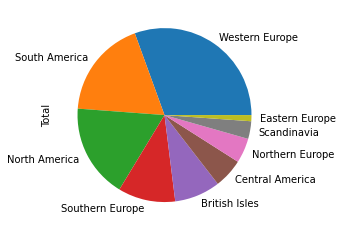

In [80]:
# 5 Points
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename)
sql_statement = ex4(conn)
data = pd.read_csv("ex4.csv")
cur = conn.cursor()
df = pd.read_sql_query(sql_statement, conn)
assert df.equals(data) == True

df.set_index('Region', inplace=True)
df.plot.pie(y='Total', legend=False)

In [81]:
def ex5(conn):
    
    # Simply, find the total for all the countries
    # Write an SQL statement that SELECTs From the OrderDetail table and joins with the Customer, Product, and Country table.
    # Pull out the following columns. 
    # Country
    # Total -- which is calculated from multiplying ProductUnitPrice with QuantityOrdered -- sum first and then round to two decimal places
    # ORDER BY Total Descending 
    # YOUR CODE HERE
    sql_statement = f"SELECT Country.Country, ROUND(sum(Product.ProductUnitPrice*OrderDetail.QuantityOrdered),2) as Total FROM OrderDetail INNER JOIN Customer, Product, Country on OrderDetail.CustomerID = Customer.CustomerID AND OrderDetail.ProductID = Product.ProducTID AND Customer.CountryID = Country.CountryID GROUP BY Country.Country ORDER BY Total DESC "
    df = pd.read_sql_query(sql_statement, conn)
    return sql_statement

<AxesSubplot:ylabel='Total'>

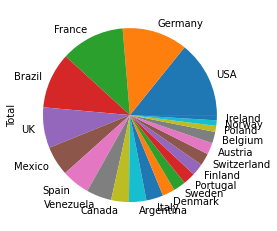

In [82]:
# 5 Points
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename)
sql_statement = ex5(conn)
data = pd.read_csv("ex5.csv")
cur = conn.cursor()
df = pd.read_sql_query(sql_statement, conn)
assert df.equals(data) == True

df.set_index('Country', inplace=True)
df.plot.pie(y='Total', legend=False)

# 20 Points
# Did the student use executemany for all the insertions? You will get these points after due date. 